# Five Models for Classifying Credit Card Fraud

This notebook contains code for building five classifier models used to predict credit card fraud.  The data set used is the [Credit Card Fraud Detection dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) from Kaggle, which contains 284,807 credit card transactions made in September 2013 by credit cardholders.  Of the 284,807 transactions, 492 (0.172%) are fraudulent.  The dataset consists of 31 columns of numerical data.  Three of the columns are time (number of seconds between the first transaction in the dataset and the current transaction), amount of transaction, and class (1 = fraudulent; 0 = not fraudulent).  The remaining columns are designated as V1, V2, etc.  The variables in these columns were obtained using Principal Component Analysis (PCA) to transform data about each transaction.  We do not know what the original data features are because that information is confidential.

The models built with this notebook are:
1. Decision Tree
2. Gradient Boosting
3. Random Forest
4. Bagging Classifier
4. XGBoost

Model building and analysis of each model are done with the scikit-learn library.

In [1]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [3]:
# Load Credit Card Fraud Detection Dataset into a DataFrame
df_fraud = pd.read_csv(Path('creditcard.csv'))
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Define features by dropping the target column, Class
X = df_fraud.copy()
X.drop('Class', axis=1, inplace=True)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [5]:
# Define target vector, which is the Class column
y = df_fraud['Class']

In [6]:
# List value counts for target vector (0 = not fraud; 1 = fraud)
y.value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Splitting into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200)

In [8]:
# Scale data using RobustScaler
scaler = RobustScaler()

# Fit scaler with training data
X_scaler = scaler.fit(X_train)

# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Decision Tree Model

In [9]:
# Create the decision tree modelinstance, fit the model, and make predictions
dt_model = tree.DecisionTreeClassifier()
dt_model = dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)

Decision Tree Confusion Matrix


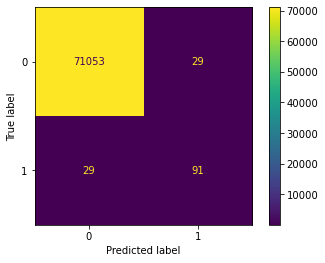

In [10]:
# Evaluate the decision tree model using the confusion matrix
dt_cm = confusion_matrix(y_test, dt_predictions)

# Display confusion matrix
print("Decision Tree Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=dt_model.classes_)
disp.plot()

In [11]:
# Calculate the accuracy score and AUC
dt_acc_score = accuracy_score(y_test, dt_predictions)
dt_auc = roc_auc_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions)

# Print the metrics
print(f"Decision Tree Accuracy Score : {dt_acc_score}")
print(f"Decision Tree AUC : {dt_auc}")
print(f"Decision Tree F1 Score: {dt_f1}")
print("Decision Tree Classification Report")
print(classification_report(y_test, dt_predictions))

Decision Tree Accuracy Score : 0.9991854161399961
Decision Tree AUC : 0.8789626769083593
Decision Tree F1 Score: 0.7583333333333333
Decision Tree Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.76      0.76      0.76       120

    accuracy                           1.00     71202
   macro avg       0.88      0.88      0.88     71202
weighted avg       1.00      1.00      1.00     71202



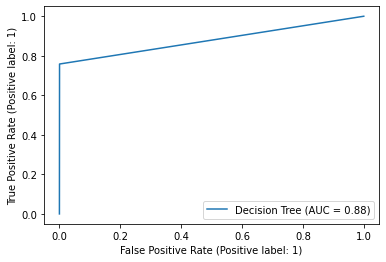

In [13]:
# Plot decision tree ROC with AUC value shown
RocCurveDisplay.from_predictions(y_test, dt_predictions, name='Decision Tree')
plt.show()

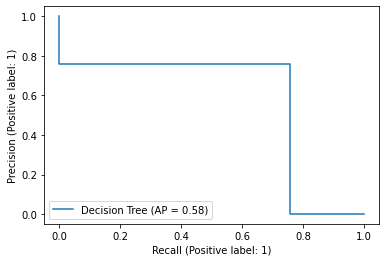

In [14]:
# Plot decision tree precision-recall curve
PrecisionRecallDisplay.from_predictions(y_test, dt_predictions, name='Decision Tree')
plt.show()

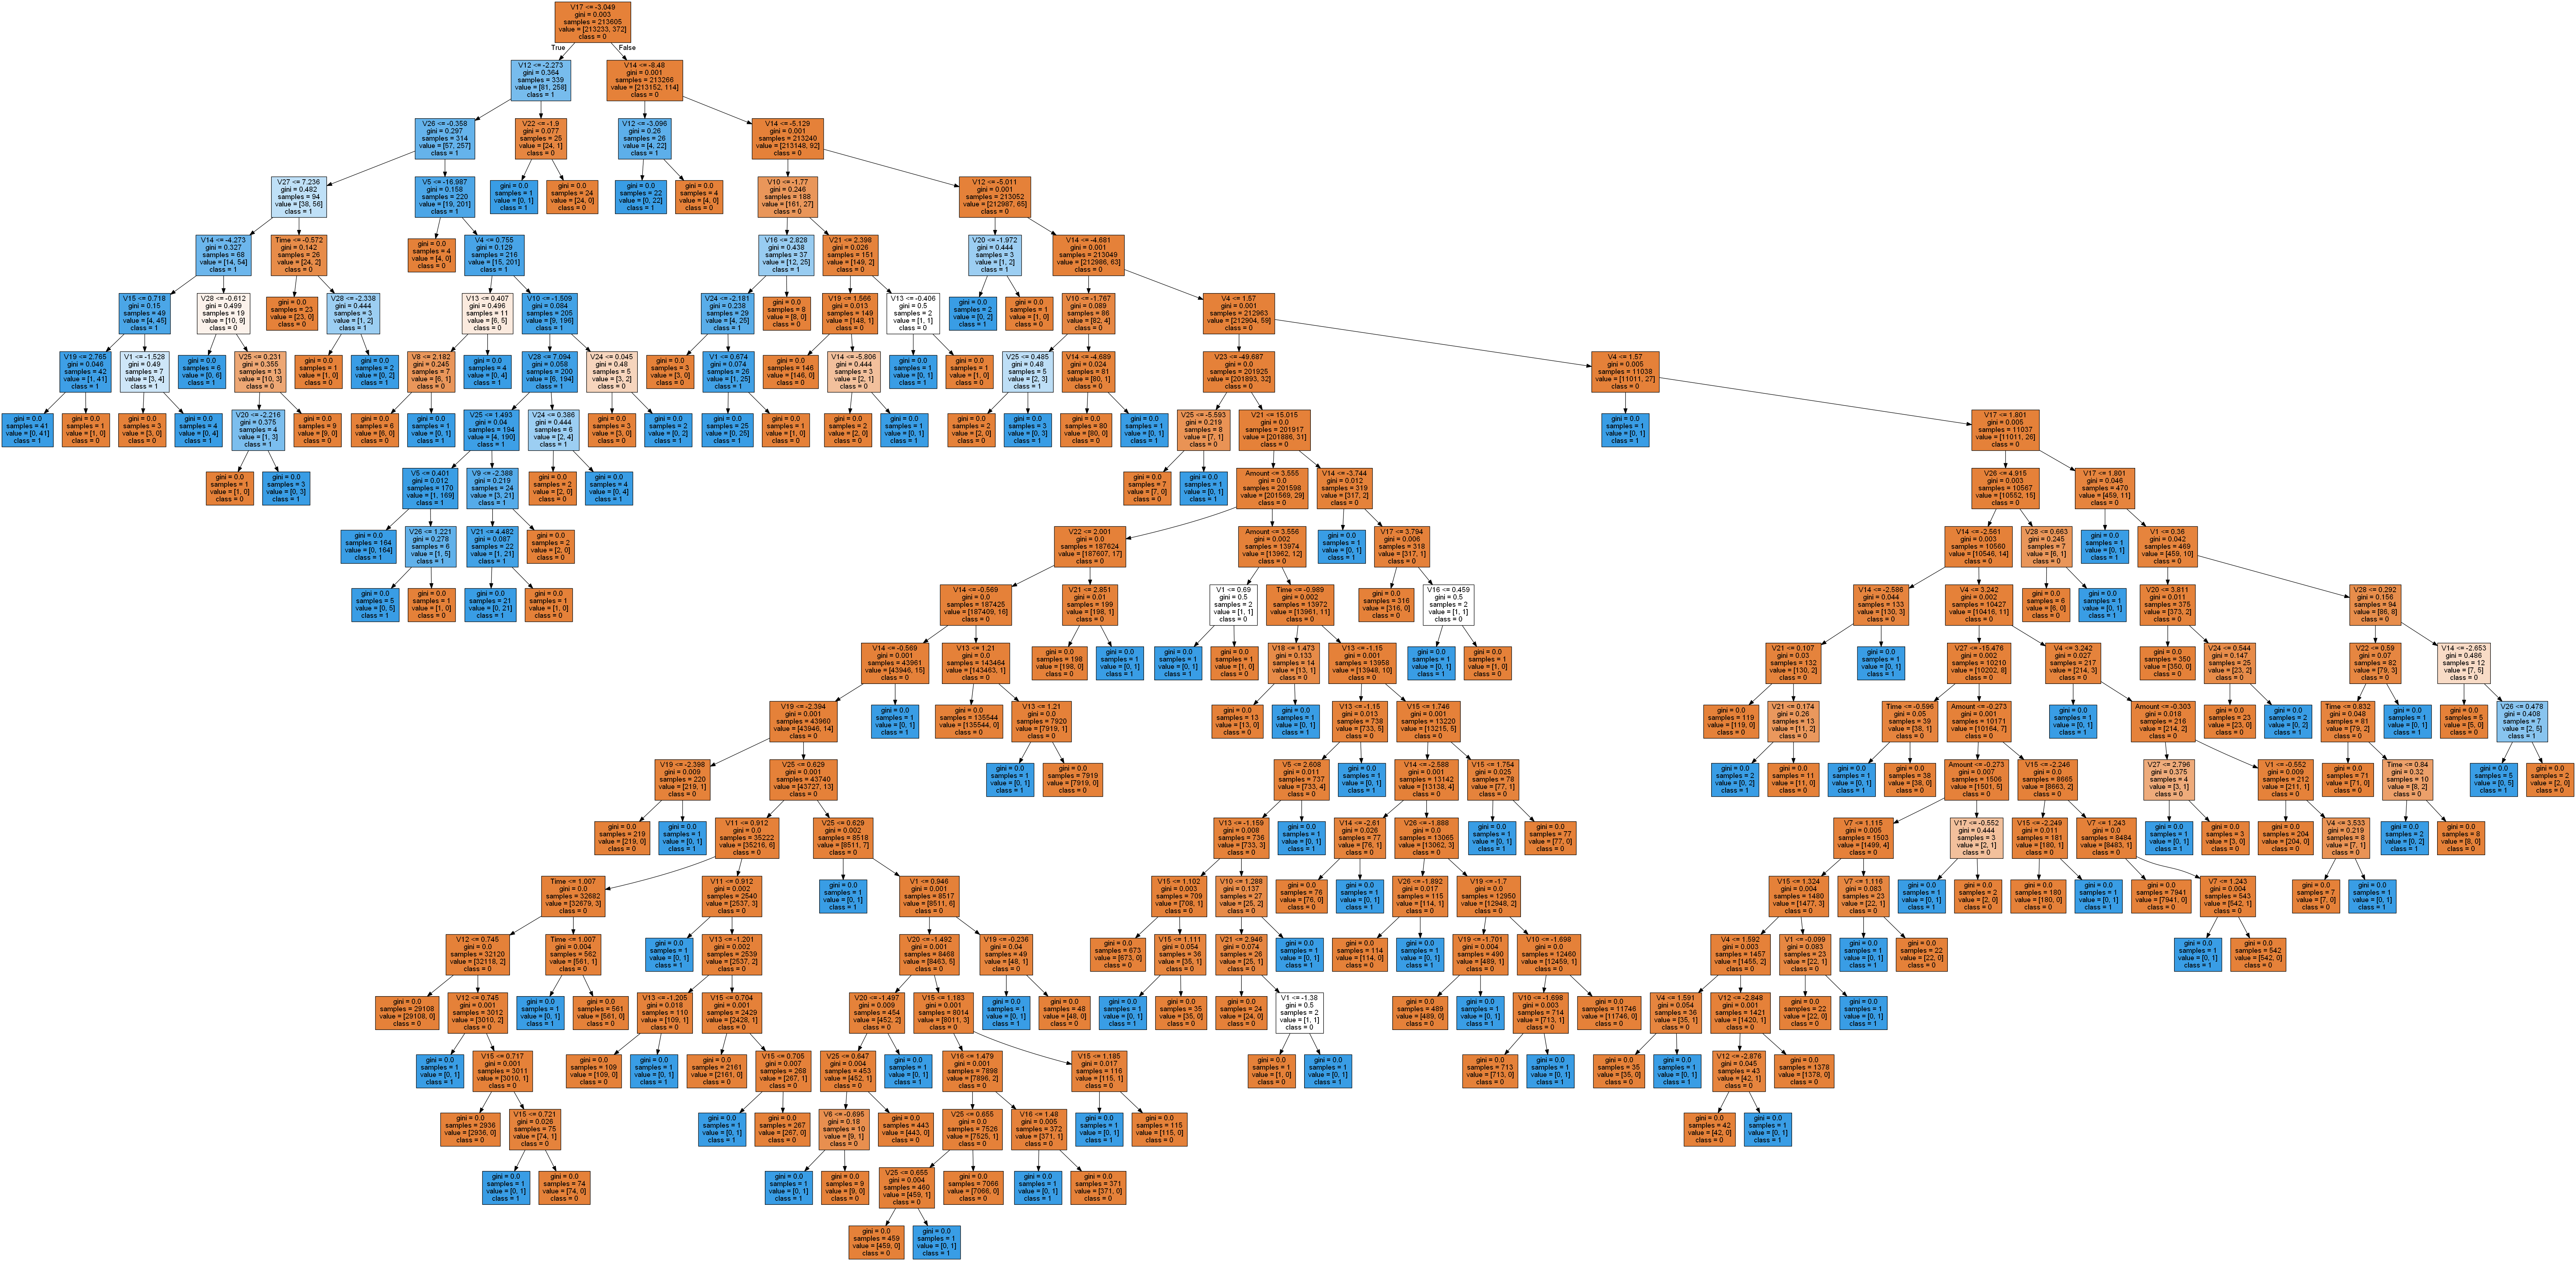

In [15]:
# Visualize the decision tree
# Create DOT data
dot_data = tree.export_graphviz(
    dt_model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

## Gradient Boosting Model

In [18]:
# Choose optimal learning rate
# Create gradeint boosting model object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=learning_rate,
        max_features=2,
        max_depth=3,
        random_state=0
    )

# Fit the model
    model.fit(X_train_scaled, y_train.ravel())

In [21]:
# Create model using the learning rate wtih the best accuracy score
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_features=2,
    max_depth=3,
    random_state=0
)

# Fit the model
gb_model.fit(X_train_scaled, y_train.ravel())

# Make predictions
gb_predictions = gb_model.predict(X_test_scaled)

In [ ]:
# Evaluate the gradient boosting model using the confusion matrix
gb_cm = confusion_matrix(y_test, gb_predictions)

# Display confusion matrix
print("Gradient Boosting Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=gb_model.classes_)
disp.plot()

In [23]:
# Calculate the gradient boosting accuracy score and AUC
gb_acc_score = accuracy_score(y_test, gb_predictions)
gb_auc = roc_auc_score(y_test, gb_predictions)
gb_f1 = f1_score(y_test, gb_predictions)

# Print the metrics
print(f"Gradient Boosting Accuracy Score : {gb_acc_score}")
print(f"Gradient Boosting AUC : {gb_auc}")
print(f"Gradient Boosting F1 Score: {gb_f1}")
print("Gradient Boosting Classification Report")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Accuracy Score : 0.9988343024072357
Gradient Boosting AUC : 0.8080730705382516
Gradient Boosting F1 Score: 0.6406926406926408
Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.67      0.62      0.64       120

    accuracy                           1.00     71202
   macro avg       0.83      0.81      0.82     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
# Print imbalanced classification report
print(classification_report_imbalanced(y_test, gb_predictions))

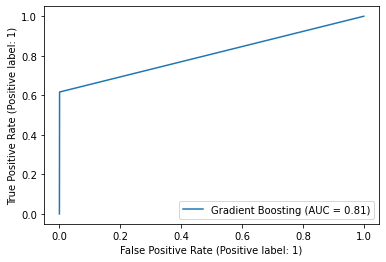

In [24]:
# Plot Gradient Boosting ROC with AUC value shown
RocCurveDisplay.from_predictions(y_test, gb_predictions, name='Gradient Boosting')
plt.show()

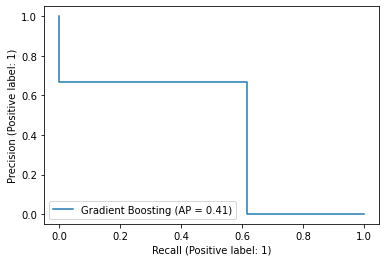

In [25]:
# Plot gradient boosting precision-recall curve
PrecisionRecallDisplay.from_predictions(y_test, gb_predictions, name='Gradient Boosting')
plt.show()

## Random Forest Model

In [26]:
# Create a random forest model, fit the model, and make predictions
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

In [27]:
# Create the random forest model instance, fit the model, and make predictions
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

Randome Foest Confusion Matrix


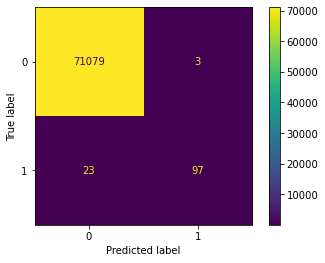

In [28]:
# Evaluate the random forest model using the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)

# Display confusion matrix
print("Randome Foest Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_)
disp.plot()

In [29]:
# Calculate the random foreast accuracy score and AUC
rf_acc_score = accuracy_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

# Print the metrics
print(f"Random Forest Accuracy Score : {rf_acc_score}")
print(f"Random Forest AUC : {rf_auc}")
print(f"Random Forest F1 Score: {rf_f1}")
print("Random Forest Classification Report")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy Score : 0.9996348417179293
Random Forest AUC : 0.9041455642778764
Random Forest F1 Score: 0.8818181818181818
Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.97      0.81      0.88       120

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



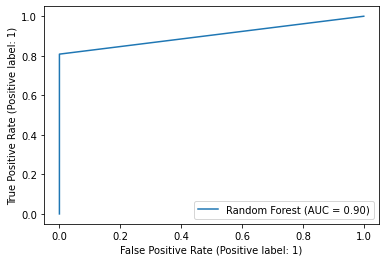

In [30]:
# Plot random forest ROC with AUC value shown
RocCurveDisplay.from_predictions(y_test, rf_predictions, name='Random Forest')
plt.show()

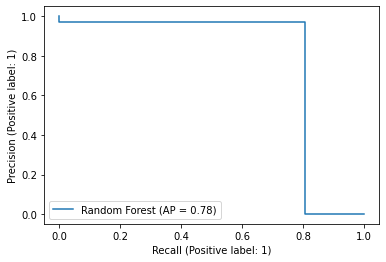

In [31]:
# Plot random forest precision-recall curve
PrecisionRecallDisplay.from_predictions(y_test, rf_predictions, name='Random Forest')
plt.show()

In [32]:
# Fetch the freatures importance and display the top 10 most important features
importances = rf_model.feature_importances_
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.15961083504686005, 'V17'),
 (0.12426437703262859, 'V12'),
 (0.11948368609883558, 'V14'),
 (0.07619094860474489, 'V11'),
 (0.07133697767200792, 'V16'),
 (0.07106983945109997, 'V10'),
 (0.0346333085433036, 'V9'),
 (0.028530294261846237, 'V18'),
 (0.028099408007603528, 'V4'),
 (0.02788479984673575, 'V7')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

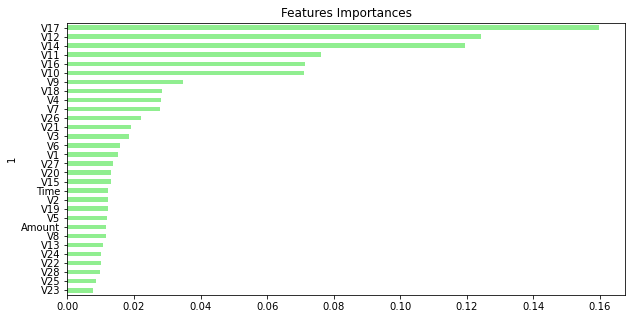

In [33]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize=(10,5))


## Bagging Classifier Model

In [34]:
# Create the bagging classifier model instance, fit the model, and make predictions
bag_model = BaggingClassifier(base_estimator=SVC(), n_estimators=100, random_state=1)
bag_model = bag_model.fit(X_train_scaled, y_train)
bag_predictions = bag_model.predict(X_test_scaled)

Bagging Classifier Confusion Matrix


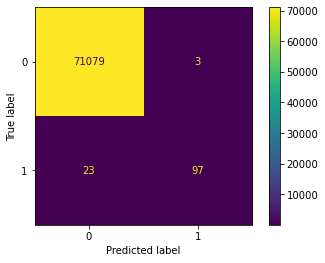

In [35]:
# Evaluate the bagging classifier model using the confusion matrix
bag_cm = confusion_matrix(y_test, rf_predictions)

# Display confusion matrix
print("Bagging Classifier Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=bag_cm, display_labels=bag_model.classes_)
disp.plot()

In [36]:
# Calculate the bagging classifier accuracy score and AUC
bag_acc_score = accuracy_score(y_test, bag_predictions)
bag_auc = roc_auc_score(y_test, bag_predictions)
bag_f1 = f1_score(y_test, bag_predictions)

# Print the metrics
print(f"Bagging Classifier Accuracy Score : {bag_acc_score}")
print(f"Bagging Classifier AUC : {bag_auc}")
print(f"Bagging Classifier F1 Score: {bag_f1}")
print("Bagging Classifier Classification Report")
print(classification_report(y_test, bag_predictions))

Bagging Classifier Accuracy Score : 0.9993820398303418
Bagging Classifier AUC : 0.8291455642778763
Bagging Classifier F1 Score: 0.7821782178217823
Bagging Classifier Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.96      0.66      0.78       120

    accuracy                           1.00     71202
   macro avg       0.98      0.83      0.89     71202
weighted avg       1.00      1.00      1.00     71202



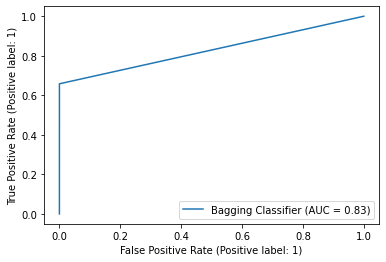

In [37]:
# Plot bagging classifier ROC with AUC value shown
RocCurveDisplay.from_predictions(y_test, bag_predictions, name='Bagging Classifier')
plt.show()

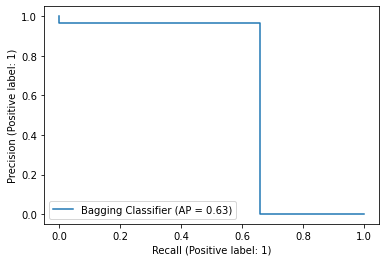

In [38]:
# Plot bagging classifier precision-recall curve
PrecisionRecallDisplay.from_predictions(y_test, bag_predictions, name='Bagging Classifier')
plt.show()

## XGBoost (Extreme Gradient Boosting) Model

In [39]:
# Create the XGBoost model instance, fit the model, and make predictions
xgb_model = XGBClassifier(max_depth=4, use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)
xgb_predictions = xgb_model.predict(X_test_scaled)

[23:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBoost Confusion Matrix


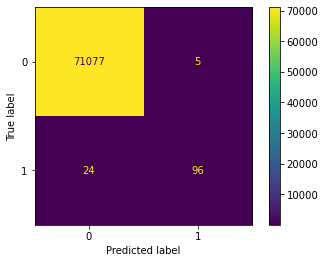

In [40]:
# Evaluate the XGBoost model using the confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Display confusion matrix
print("XGBoost Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
disp.plot()

In [41]:
# Calculate the XGBoost accuracy score and AUC
xgb_acc_score = accuracy_score(y_test, xgb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

# Print the metrics
print(f"XGBoost Accuracy Score : {xgb_acc_score}")
print(f"XGBoost AUC : {xgb_auc}")
print(f"XGBost F1 Score: {xgb_f1}")
print("XGBoost Classification Report")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy Score : 0.999592708069998
XGBoost AUC : 0.8999648293520159
XGBost F1 Score: 0.8687782805429864
XGBoost Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.95      0.80      0.87       120

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202



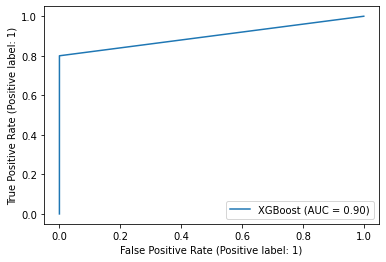

In [42]:
# Plot XGBoost ROC with AUC value shown
RocCurveDisplay.from_predictions(y_test, xgb_predictions, name='XGBoost')
plt.show()

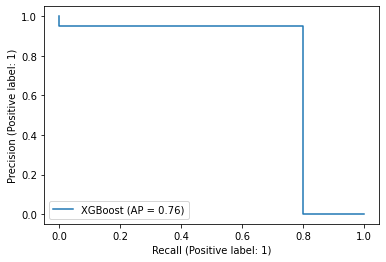

In [43]:
# Plot XGBoost precision-recall curve
PrecisionRecallDisplay.from_predictions(y_test, xgb_predictions, name='XGBoost')
plt.show()